In [10]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'mejiro':
    path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

In [11]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rc
from hydra import initialize, compose
from lenstronomy.Plots import lens_plot
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.SimulationAPI.ObservationConfig.Roman import Roman
import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Plots import plot_util

from mejiro.lenses import tutorial_lens

# from mejiro.plots import plot

plt.style.use(f'{repo_path}/mejiro/mplstyle/science.mplstyle')

In [12]:
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, repo_dir, pickle_dir = config.machine.array_dir, config.machine.data_dir, config.machine.repo_dir, config.machine.pickle_dir
array_dir = os.path.join(array_dir, 'sample_skypy_lens')
figure_dir = os.path.join(repo_dir, 'figures')

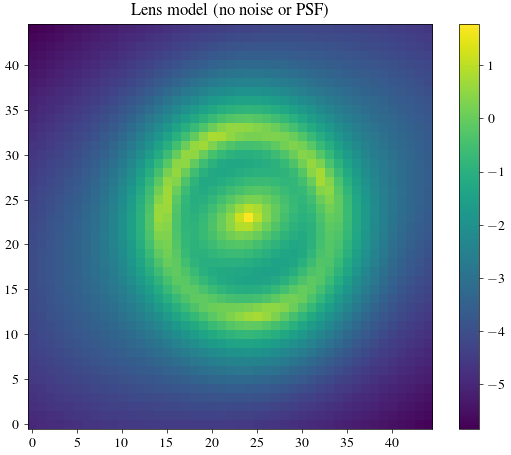

(45, 45)


In [17]:
lens = tutorial_lens.TestLens()
num_pix = 45

test_model = lens.get_array(num_pix=num_pix)

plt.imshow(np.log10(test_model))
plt.title('Lens model (no noise or PSF)')
plt.colorbar()
plt.show()

print(test_model.shape)

Overplot caustics and critical curve

0.09566681002252231 -0.0639623054267272
[ 5.15505496  9.90090574 -7.34855686 -4.94970695]


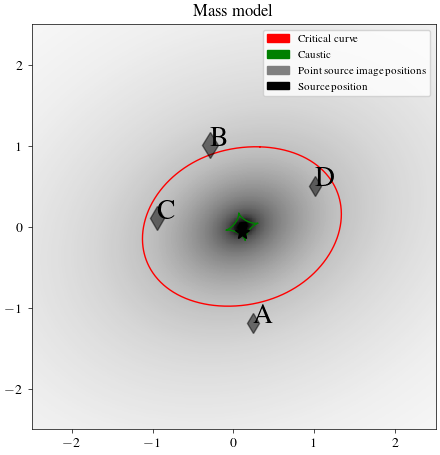

In [14]:
# source plane coordinates of source
beta_ra, beta_dec = lens.kwargs_source[0]['center_x'], lens.kwargs_source[0]['center_y']
print(beta_ra, beta_dec)

# specify the lens model class to deal with
solver = LensEquationSolver(lens.lens_model_class)

# solve for image positions provided a lens model and the source position
theta_ra, theta_dec = solver.image_position_from_source(beta_ra, beta_dec, lens.kwargs_lens)

# the magnification of the point source images
mag = lens.lens_model_class.magnification(theta_ra, theta_dec, lens.kwargs_lens)
print(mag)

# plot
f, axes = plt.subplots()
lens_plot.lens_model_plot(axes, lensModel=lens.lens_model_class, kwargs_lens=lens.kwargs_lens, sourcePos_x=beta_ra,
                          sourcePos_y=beta_dec, point_source=True, with_caustics=True, fast_caustic=True,
                          coord_inverse=False)
axes.set_title('Mass model')
red_patch = mpatches.Patch(color='r', label='Critical curve')
blue_patch = mpatches.Patch(color='g', label='Caustic')
grey_patch = mpatches.Patch(color='grey', label='Point source image positions')
black_patch = mpatches.Patch(color='black', label='Source position')
axes.legend(loc=0, prop={'size': 8}, handles=[red_patch, blue_patch, grey_patch, black_patch])
axes.xaxis.set_ticks_position("bottom")
f.show()

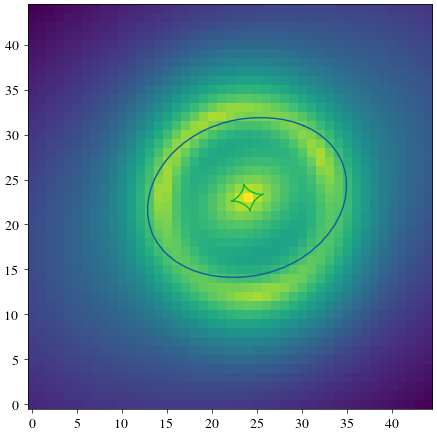

In [27]:
model_extension = LensModelExtensions(lens.lens_model_class)

frame_size = lens.delta_pix * num_pix

ra_critical_list, dec_critical_list, ra_caustic_list, dec_caustic_list = model_extension.critical_curve_caustics(
    lens.kwargs_lens, compute_window=frame_size, grid_scale=lens.delta_pix, center_x=0., center_y=0.)

x_critical_list, y_critical_list = [], []
for ra, dec in zip(ra_critical_list[0], dec_critical_list[0]):
    x, y = lens.coords.map_coord2pix(ra=ra, dec=dec)
    x_critical_list.append(x)
    y_critical_list.append(y)

x_caustic_list, y_caustic_list = [], []
for ra, dec in zip(ra_caustic_list[0], dec_caustic_list[0]):
    x, y = lens.coords.map_coord2pix(ra=ra, dec=dec)
    x_caustic_list.append(x)
    y_caustic_list.append(y)

fig, ax = plt.subplots()

ax.imshow(np.log10(test_model))
ax.plot(x_critical_list, y_critical_list)
ax.plot(x_caustic_list, y_caustic_list)

ax.xaxis.set_ticks_position("bottom")

plt.show()

Combine

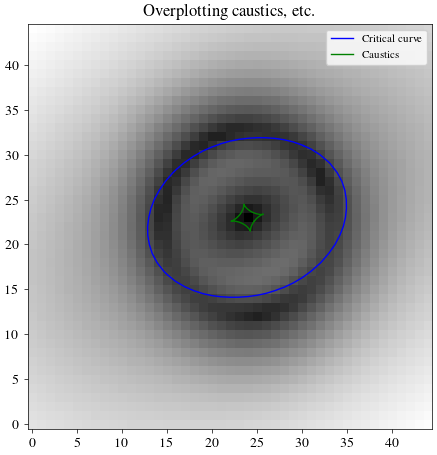

In [28]:
fig, ax = plt.subplots()

ax.imshow(np.log10(test_model), cmap='binary')
ax.plot(x_critical_list, y_critical_list, label='Critical curve', color='b')
ax.plot(x_caustic_list, y_caustic_list, label='Caustics', color='g')
# ax.scatter(source_x, source_y, edgecolor='y', facecolor='none', s=50, label='Source position')
# ax.scatter(lens_x, lens_y, edgecolor='r', facecolor='none', s=50, label='Lens position')

ax.legend(loc=0, prop={'size': 8})  # , handles=[red_patch, blue_patch, grey_patch, black_patch]
ax.xaxis.set_ticks_position("bottom")

plt.title('Overplotting caustics, etc.')
plt.show()